# Diagnosis Analysis and Categorization

**Goal**: Analyze current diagnosis distribution and create a hierarchical categorization system to group similar diagnoses together.

**Problem**: Many specific diagnoses (e.g., "Glioblastoma", "Astrocytoma", "Meningioma") should be grouped under broader categories (e.g., "Brain Tumor") to:
- Reduce the number of small clusters
- Make UMAP visualization more meaningful
- Prevent most cases from falling into "Other" category

In [19]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
with open('../data/processed/cases_cleaned.json', 'r') as f:
    cases = json.load(f)

print(f"Total cases: {len(cases)}")
print(f"\nFirst case diagnosis example:\n{cases[0]['diagnosis']}")

Total cases: 7432

First case diagnosis example:
A Neck And Wrist Pain: Bilateral Carpal Tunnel Syndrome, Cervical Subluxation Knee Pain: Post-Traumatic Osteoarthritis, Chronic ACL & PCL Tears, Torn Lateral Meniscus Back Pain: Traumatic Herniated Discs At L4-L5 And L5-S1 With Lumbar Radiculopathy B Patient B Was Diagnosed With A Compression Fracture In The Vertebral Body Of L2, Greater Trochanteric Bursitis With Tendinopathy Of The Inserting Gluteus Medius Tendon, And A Bone Contusion Of The Tibia.


## Step 1: Current Diagnosis Distribution

In [20]:
# Extract all diagnoses
diagnoses = [case.get('diagnosis', 'Unknown') for case in cases]

# Count unique diagnoses
diagnosis_counts = Counter(diagnoses)

print(f"Unique diagnoses: {len(diagnosis_counts)}")
print(f"\nTop 50 most common diagnoses:")
for diagnosis, count in diagnosis_counts.most_common(50):
    print(f"{count:5d} - {diagnosis[:100]}..." if len(diagnosis) > 100 else f"{count:5d} - {diagnosis}")

Unique diagnoses: 4021

Top 50 most common diagnoses:
   80 - Osteochondroma
   32 - Acute Appendicitis
   32 - Osteoid Osteoma
   29 - Meningioma
   28 - Bicornuate Uterus
   28 - Osteochondritis Dissecans
   28 - Osteomyelitis
   28 - Osteosarcoma
   24 - Brain Death
   24 - Osteogenesis Imperfecta
   20 - Brain, Cerebral Abscess
   20 - Ovarian Torsion
   19 - Hypertrophic Pyloric Stenosis
   18 - Fibrous Dysplasia
   18 - Multiple Sclerosis
   17 - Angiomyolipoma
   17 - Glioblastoma Multiforme
   16 - Blowout Fracture Of Orbit
   16 - Occult Stress Fracture
   16 - Oligodendroglioma
   16 - Omphalocele
   16 - Orchitis
   16 - OSTEOMYELITIS
   16 - Renal Cell Carcinoma
   15 - Achalasia
   14 - Arachnoid Cyst
   13 - Ectopic Pregnancy
   13 - Hiatal Hernia
   13 - Sarcoidosis
   12 - Benign Cystic Teratoma
   12 - Bilateral Subacute (Isodense) Subdural Hematomas
   12 - Blount'S Disease
   12 - Branchial Cleft Cyst
   12 - Breast Cancer, Metastatic
   12 - Breast Hamartoma (Fibroa

In [21]:
# Analyze diagnosis frequency distribution
counts = list(diagnosis_counts.values())
df_counts = pd.DataFrame(counts, columns=['Count'])

print(f"\nDiagnosis frequency statistics:")
print(df_counts.describe())

# How many diagnoses appear only once, twice, etc?
frequency_dist = Counter(counts)
print(f"\nDiagnoses appearing exactly once: {frequency_dist[1]}")
print(f"Diagnoses appearing 2-5 times: {sum(frequency_dist[i] for i in range(2, 6) if i in frequency_dist)}")
print(f"Diagnoses appearing 6-10 times: {sum(frequency_dist[i] for i in range(6, 11) if i in frequency_dist)}")
print(f"Diagnoses appearing >10 times: {sum(1 for c in counts if c > 10)}")


Diagnosis frequency statistics:
             Count
count  4021.000000
mean      1.848296
std       2.590235
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      80.000000

Diagnoses appearing exactly once: 3005
Diagnoses appearing 2-5 times: 852
Diagnoses appearing 6-10 times: 113
Diagnoses appearing >10 times: 51


## Step 2: Identify Key Medical Categories

We'll create a hierarchical categorization based on medical taxonomy:
1. **Brain Tumors** - All types of brain tumors (glioblastoma, astrocytoma, meningioma, etc.)
2. **Vascular Conditions** - Strokes, aneurysms, hemorrhages, etc.
3. **Trauma** - Fractures, contusions, lacerations
4. **Infections** - Abscesses, meningitis, encephalitis
5. **Degenerative** - Alzheimer's, MS, atrophy
6. **Congenital** - Birth defects, malformations
7. **And more...**

In [22]:
# Define keyword patterns for major categories
# Based on actual data analysis - these categories exist in the MedPix dataset

category_patterns = {
    'Brain/CNS Tumor': [
        r'\bglioblastoma\b', r'\bgbm\b', r'\bastrocytoma\b', r'\bmeningioma\b', 
        r'\bependymoma\b', r'\boligodendroglioma\b', r'\bmedulloblastoma\b', 
        r'\bcraniopharyngioma\b', r'\bpineoblastoma\b', r'\bpituitary adenoma\b', 
        r'\bpituitary macroadenoma\b', r'\bpituitary microadenoma\b', r'\bacth.*pituitary\b',
        r'\bacromegaly.*pituitary\b', r'\bbrain.*tumor\b', r'\bbrain.*mass\b', r'\bbrain.*neoplasm\b',
        r'\bglioma\b', r'\bneurocytoma\b', r'\bgerminoma\b', r'\bchoroid plexus\b',
        r'\bvestibular schwannoma\b', r'\bacoustic schwannoma\b', r'\bschwannoma\b',
        r'\bhemangioblastoma\b', r'\bcerebellar hemangioblastoma\b',
        r'\bcns lymphoma\b', r'\blymphoma.*brain\b', r'\bprimary cns lymphoma\b',
        r'\bmetasta.*brain\b', r'\bbrain.*metasta\b', r'\bcerebral.*tumor\b'
    ],
    
    'Brain/CNS Vascular & Hemorrhage': [
        r'\bintracranial hemorrhage\b', r'\bsubarachnoid hemorrhage\b', r'\bsah\b',
        r'\bsubdural.*hematoma\b', r'\bsdh\b', r'\bepidural.*hematoma\b', r'\bedh\b',
        r'\bintraparenchymal.*hemorrhage\b', r'\bintraventricular.*hemorrhage\b',
        r'\bbasilar.*aneurysm\b', r'\baneurysm\b', r'\bavm\b', r'\barteriovenous malformation\b',
        r'\bcerebral infarct\b', r'\bischemic stroke\b', r'\bstroke\b', r'\bcva\b',
        r'\bcerebrovascular accident\b', r'\bembolic\b', r'\bthrombotic\b',
        r'\bmca.*occlusion\b', r'\baca.*occlusion\b', r'\bpca.*occlusion\b',
        r'\bflair.*hemorrhage\b', r'\bcavernous malformation\b', r'\bcavernoma\b'
    ],
    
    'Spine Degenerative': [
        r'\bdisc herniation\b', r'\bherniated disc\b', r'\bdisc.*herniation\b',
        r'\bdegenerative disc disease\b', r'\bdisc.*degeneration\b',
        r'\bspinal stenosis\b', r'\bspondylosis\b', r'\bspondylotic\b',
        r'\bneural foramina.*stenosis\b', r'\bforaminal stenosis\b',
        r'\bfacet.*arthropathy\b', r'\bspine.*degenerative\b'
    ],
    
    'Spine Trauma': [
        r'\bspinal.*fracture\b', r'\bvertebral.*fracture\b', r'\bvertebral body.*fracture\b',
        r'\bcompression fracture.*vertebra\b', r'\bburst fracture\b',
        r'\bankylosing spondylitis.*fracture\b', r'\bfracture.*disc space\b',
        r'\bspine.*trauma\b', r'\bcervical.*fracture\b', r'\bthoracic.*fracture\b', 
        r'\blumbar.*fracture\b'
    ],
    
    'Musculoskeletal Trauma/Fracture': [
        r'\bacetabular fracture\b', r'\bdistal.*fracture\b', r'\btibial.*fracture\b',
        r'\bfemur.*fracture\b', r'\bfemoral.*fracture\b', r'\bhumeral.*fracture\b',
        r'\bradial.*fracture\b', r'\bulnar.*fracture\b', r'\bskull fracture\b',
        r'\bavulsion fracture\b', r'\bsegond fracture\b', r'\bkissing contusion\b',
        r'\bacl tear\b', r'\bpcl tear\b', r'\bmcl.*sprain\b', r'\blcl.*sprain\b',
        r'\bmeniscus.*tear\b', r'\bmeniscal tear\b', r'\bligament.*tear\b',
        r'\bligament.*rupture\b', r'\btendon.*rupture\b', r'\btendon.*tear\b',
        r'\bachilles.*rupture\b', r'\brotator cuff.*tear\b',
        r'\bfracture\b', r'\btrauma\b', r'\btraumatic\b', r'\bcontusion\b',
        r'\blaceration\b', r'\bpost-traumatic\b'
    ],
    
    'Musculoskeletal Tumor': [
        r'\bosteosarcoma\b', r'\bewing.*sarcoma\b', r'\bewing sarcoma\b',
        r'\benchondroma\b', r'\bgiant cell tumor\b', r'\bchondrosarcoma\b',
        r'\bmetastatic bone disease\b', r'\bbone.*metasta\b', r'\bmetasta.*bone\b',
        r'\bbone.*tumor\b', r'\bbone.*mass\b', r'\bbone.*neoplasm\b',
        r'\bsoft tissue.*sarcoma\b', r'\bliposarcoma\b', r'\bfibrosarcoma\b'
    ],
    
    'Infection/Inflammatory': [
        r'\bosteomyelitis\b', r'\bacute osteomyelitis\b', r'\bchronic osteomyelitis\b',
        r'\bdiscitis\b', r'\bspondylodiscitis\b', r'\bseptic arthritis\b',
        r'\bcellulitis\b', r'\babscess\b', r'\binfection\b', r'\binfected\b',
        r'\bmeningitis\b', r'\bencephalitis\b', r'\bempyema\b',
        r'\bpneumonia\b', r'\btuberculosis\b', r'\btb\b'
    ],
    
    'Vascular (Non-CNS)': [
        r'\babdominal.*aortic.*aneurysm\b', r'\baaa\b', r'\baortic.*aneurysm\b',
        r'\baortic dissection\b', r'\bdissection.*aorta\b',
        r'\bdeep vein thrombosis\b', r'\bdvt\b', r'\bthrombosis\b',
        r'\bpulmonary embol\b', r'\bpe\b(?!d)', r'\bembolus\b'
    ],
    
    'Thoracic/Pulmonary': [
        r'\bpneumothorax\b', r'\bpneumomediastinum\b', r'\bpleural effusion\b',
        r'\blung.*carcinoma\b', r'\blung.*adenocarcinoma\b', r'\bbronchogenic carcinoma\b',
        r'\bpulmonary.*nodule\b', r'\blung.*mass\b', r'\blung.*tumor\b',
        r'\bpulmonary.*mass\b', r'\bpulmonary.*lesion\b'
    ],
    
    'Abdominal/GI': [
        r'\bappendicitis\b', r'\bacute.*appendicitis\b', r'\bcholecystitis\b',
        r'\bacute cholecystitis\b', r'\bacalculous.*cholecystitis\b',
        r'\bpancreatitis\b', r'\bbowel obstruction\b', r'\bintestinal obstruction\b',
        r'\bcrohn.*disease\b', r'\bcrohn\b', r'\bulcerative colitis\b',
        r'\bgastric.*adenocarcinoma\b', r'\bstomach.*cancer\b',
        r'\bcolon.*adenocarcinoma\b', r'\bcolorectal.*carcinoma\b',
        r'\bsplenic.*laceration\b', r'\bliver.*laceration\b', r'\bhepatic.*laceration\b',
        r'\babdominal.*trauma\b'
    ],
    
    'Urologic/Renal': [
        r'\brenal cell carcinoma\b', r'\bkidney.*cancer\b', r'\bkidney.*tumor\b',
        r'\bnephrolithiasis\b', r'\bkidney stone\b', r'\brenal.*stone\b',
        r'\bhydronephrosis\b', r'\bbladder.*carcinoma\b', r'\bbladder.*cancer\b',
        r'\burologic\b', r'\brenal.*mass\b'
    ],
    
    'OB/GYN': [
        r'\bectopic pregnancy\b', r'\bovarian torsion\b', r'\badnexal torsion\b',
        r'\buterine fibroid\b', r'\bleiomyoma\b', r'\bovarian cyst\b',
        r'\bovarian.*neoplasm\b', r'\bovarian.*mass\b', r'\buterine.*mass\b'
    ],
    
    'Cardiac': [
        r'\bmyocardial infarction\b', r'\bmi\b(?!c)', r'\bheart attack\b',
        r'\bcardiomyopathy\b', r'\bpericardial effusion\b', r'\bcardiac.*mass\b',
        r'\bcardiac.*tumor\b', r'\bcoronary.*disease\b'
    ],
    
    'Congenital/Pediatric': [
        r'\bcongenital\b', r'\bdevelopmental\b', r'\bchiari\b', r'\bdandy.*walker\b',
        r'\bagenesis\b', r'\bhypoplasia\b', r'\bdysplasia\b', r'\bmalformation\b',
        r'\bholoprosencephaly\b', r'\blissencephaly\b', r'\bschizencephaly\b',
        r'\bcongenital.*heart\b', r'\bpediatric.*anomaly\b'
    ],
    
    'Metabolic/Systemic': [
        r'\bmetabolic.*bone.*disease\b', r'\bosteoporosis\b', r'\bosteopenia\b',
        r'\bhyperparathyroidism\b', r'\bparathyroid\b', r'\bmetabolic\b',
        r'\bdementia\b', r'\batrophy\b', r'\balzheimer\b', r'\bparkinson\b',
        r'\bneurodegenerative\b', r'\bmultiple sclerosis\b', r'\bdemyelinating\b',
        r'\bhydrocephalus\b', r'\bventriculomegaly\b'
    ],
}

print("Category patterns defined:")
for category, patterns in category_patterns.items():
    print(f"  {category}: {len(patterns)} patterns")

Category patterns defined:
  Brain/CNS Tumor: 32 patterns
  Brain/CNS Vascular & Hemorrhage: 26 patterns
  Spine Degenerative: 12 patterns
  Spine Trauma: 11 patterns
  Musculoskeletal Trauma/Fracture: 30 patterns
  Musculoskeletal Tumor: 15 patterns
  Infection/Inflammatory: 16 patterns
  Vascular (Non-CNS): 11 patterns
  Thoracic/Pulmonary: 11 patterns
  Abdominal/GI: 19 patterns
  Urologic/Renal: 11 patterns
  OB/GYN: 9 patterns
  Cardiac: 8 patterns
  Congenital/Pediatric: 13 patterns
  Metabolic/Systemic: 15 patterns


## Step 3: Categorize All Diagnoses

In [23]:
def categorize_diagnosis(diagnosis_text):
    """
    Categorize a diagnosis based on keyword patterns.
    Returns the first matching category or 'Other'.
    """
    if not diagnosis_text or diagnosis_text == 'Unknown':
        return 'Unknown'
    
    diagnosis_lower = diagnosis_text.lower()
    
    # Check each category
    for category, patterns in category_patterns.items():
        for pattern in patterns:
            if re.search(pattern, diagnosis_lower, re.IGNORECASE):
                return category
    
    return 'Other'

# Test the function
test_cases = [
    "Glioblastoma Multiforme",
    "Acute Ischemic Stroke",
    "Subarachnoid Hemorrhage",
    "Skull Fracture",
    "Brain Abscess",
    "Alzheimer's Disease",
    "Some Random Diagnosis"
]

print("Testing categorization:")
for test in test_cases:
    category = categorize_diagnosis(test)
    print(f"  {test:40s} -> {category}")

Testing categorization:
  Glioblastoma Multiforme                  -> Brain/CNS Tumor
  Acute Ischemic Stroke                    -> Brain/CNS Vascular & Hemorrhage
  Subarachnoid Hemorrhage                  -> Brain/CNS Vascular & Hemorrhage
  Skull Fracture                           -> Musculoskeletal Trauma/Fracture
  Brain Abscess                            -> Infection/Inflammatory
  Alzheimer's Disease                      -> Metabolic/Systemic
  Some Random Diagnosis                    -> Other


In [24]:
# Apply categorization to all cases
categories = [categorize_diagnosis(case.get('diagnosis', '')) for case in cases]

# Count categories
category_counts = Counter(categories)

print("Category Distribution:")
print("=" * 60)
total = len(categories)
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total) * 100
    print(f"{category:30s}: {count:5d} ({percentage:5.2f}%)")

print(f"\nTotal: {total}")

Category Distribution:
Other                         :  5006 (67.36%)
Musculoskeletal Trauma/Fracture:   594 ( 7.99%)
Brain/CNS Tumor               :   430 ( 5.79%)
Infection/Inflammatory        :   319 ( 4.29%)
Brain/CNS Vascular & Hemorrhage:   213 ( 2.87%)
Congenital/Pediatric          :   203 ( 2.73%)
Abdominal/GI                  :   164 ( 2.21%)
Musculoskeletal Tumor         :   113 ( 1.52%)
Vascular (Non-CNS)            :    81 ( 1.09%)
OB/GYN                        :    71 ( 0.96%)
Urologic/Renal                :    56 ( 0.75%)
Metabolic/Systemic            :    55 ( 0.74%)
Spine Degenerative            :    50 ( 0.67%)
Thoracic/Pulmonary            :    49 ( 0.66%)
Spine Trauma                  :    15 ( 0.20%)
Unknown                       :     8 ( 0.11%)
Cardiac                       :     5 ( 0.07%)

Total: 7432


## Step 4: Visualize Category Distribution

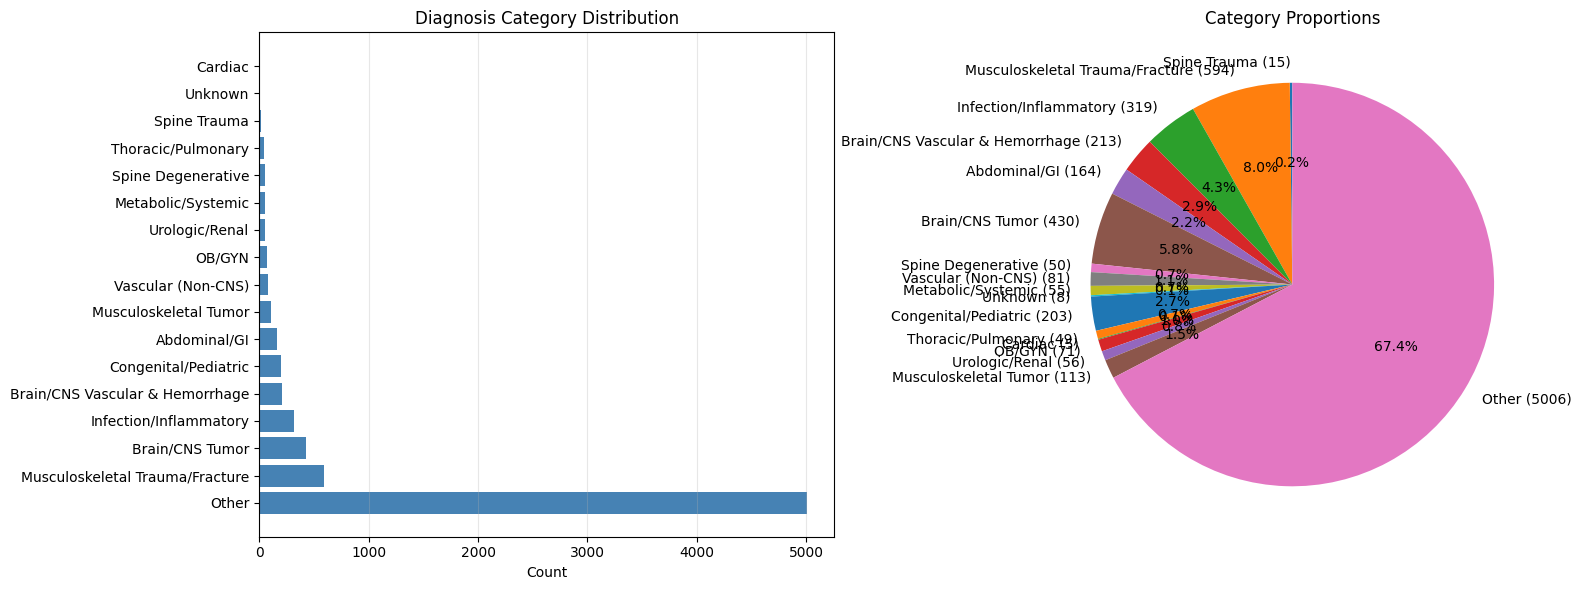


'Other' category contains 5006 cases (67.4%)


In [25]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
cats = [c[0] for c in sorted_categories]
counts = [c[1] for c in sorted_categories]

ax1.barh(cats, counts, color='steelblue')
ax1.set_xlabel('Count')
ax1.set_title('Diagnosis Category Distribution')
ax1.grid(axis='x', alpha=0.3)

# Pie chart (excluding 'Other')
pie_data = [(k, v) for k, v in category_counts.items() if k != 'Other']
pie_labels = [f"{k} ({v})" for k, v in pie_data]
pie_values = [v for k, v in pie_data]

# Add 'Other' if it exists
if 'Other' in category_counts:
    pie_labels.append(f"Other ({category_counts['Other']})")
    pie_values.append(category_counts['Other'])

ax2.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Category Proportions')

plt.tight_layout()
plt.show()

print(f"\n'Other' category contains {category_counts.get('Other', 0)} cases ({(category_counts.get('Other', 0)/total)*100:.1f}%)")

## Step 5: Analyze 'Other' Category

Let's see what diagnoses are falling into 'Other' to improve our categorization

In [26]:
# Find all 'Other' diagnoses
other_diagnoses = []
for case, category in zip(cases, categories):
    if category == 'Other':
        other_diagnoses.append(case.get('diagnosis', 'Unknown'))

# Count them
other_counts = Counter(other_diagnoses)

print(f"Top 100 diagnoses in 'Other' category:")
print("=" * 80)
for diagnosis, count in other_counts.most_common(100):
    print(f"{count:4d} - {diagnosis[:100]}..." if len(diagnosis) > 100 else f"{count:4d} - {diagnosis}")

Top 100 diagnoses in 'Other' category:
  80 - Osteochondroma
  32 - Osteoid Osteoma
  28 - Bicornuate Uterus
  28 - Osteochondritis Dissecans
  24 - Brain Death
  24 - Osteogenesis Imperfecta
  19 - Hypertrophic Pyloric Stenosis
  17 - Angiomyolipoma
  16 - Omphalocele
  16 - Orchitis
  15 - Achalasia
  14 - Arachnoid Cyst
  13 - Hiatal Hernia
  13 - Sarcoidosis
  12 - Benign Cystic Teratoma
  12 - Bilateral Subacute (Isodense) Subdural Hematomas
  12 - Blount'S Disease
  12 - Branchial Cleft Cyst
  12 - Breast Cancer, Metastatic
  12 - Breast Hamartoma (Fibroadenolipoma)
  12 - Bronchial Carcinoid
  12 - Horseshoe Kidney
  12 - Nonossifying Fibroma
  12 - Olfactory Neuroblastoma
  12 - Ollier'S Disease
  12 - Os Acromiale
  12 - Osteolysis Of Distal Clavicle.
  12 - Ovarian Dermoid (Cystic Teratoma)
  11 - Mature Cystic Teratoma
  11 - Rheumatoid Arthritis
  10 - Adenocarcinoma Of The Lung
  10 - Cholelithiasis
  10 - Hydrosalpinx
  10 - Intraosseous Lipoma
  10 - Left Aortic Arch Wit

## Step 5b: Refine Categories Based on 'Other' Analysis

Looking at the top diagnoses in "Other", we need to add more categories:
- **Benign Bone/Joint** - Osteochondroma, Osteoid Osteoma, Nonossifying Fibroma
- **Arthritis/Degenerative Joint** - Rheumatoid Arthritis, Osteoarthritis, Ankylosing Spondylitis  
- **Benign Soft Tissue Tumor** - Hemangioma, Lipoma, Cysts
- **Pediatric Tumor** - Wilms Tumor, Neuroblastoma
- **GI Functional/Benign** - Achalasia, Hiatal Hernia, Diverticulum

In [27]:
# Add additional categories based on what we found in "Other"
additional_patterns = {
    'Benign Bone/Joint Lesion': [
        r'\bosteochondroma\b', r'\bosteoid osteoma\b', r'\bosteoblastoma\b',
        r'\bnonossifying fibroma\b', r'\bfibrous cortical defect\b',
        r'\bosteochondritis dissecans\b', r'\bblount.*disease\b',
        r'\bbipartite patella\b', r'\bos acromiale\b', r'\bosteopoikilosis\b',
        r'\bintraosseous lipoma\b', r'\benchondroma\b(?!.*sarcoma)',
        r'\bbone.*cyst\b', r'\baneurysmal bone cyst\b'
    ],
    
    'Arthritis/Degenerative Joint': [
        r'\brheumatoid arthritis\b', r'\bra\b(?!d)', r'\bosteoarthritis\b',
        r'\bdegenerative joint\b', r'\berosive osteoarthritis\b',
        r'\bankylosing spondylitis\b', r'\bgout\b', r'\bpseudogout\b',
        r'\bseptic arthritis\b(?!.*infection)', r'\bsynovial.*cyst\b'
    ],
    
    'Benign Soft Tissue Mass': [
        r'\bhemangioma\b', r'\bcavernous hemangioma\b', r'\blipoma\b',
        r'\bangiomyolipoma\b', r'\bhamartoma\b', r'\bganglion.*cyst\b',
        r'\bbaker.*cyst\b', r'\bsebaceous cyst\b', r'\beparmoid.*cyst\b',
        r'\barachnoid cyst\b', r'\bcolloid cyst\b', r'\bbranchial.*cyst\b',
        r'\bthyroglossal.*cyst\b'
    ],
    
    'Pediatric Tumor (Non-CNS)': [
        r'\bwilms.*tumor\b', r'\bneuroblastoma\b', r'\bhepatoblastoma\b',
        r'\brhabdomyosarcoma\b', r'\btuberous sclerosis\b'
    ],
    
    'GI Functional/Benign': [
        r'\bachalasia\b', r'\bhiatal hernia\b', r'\bdiverticulum\b',
        r'\bdiverticulosis\b', r'\bdiverticulitis\b', r'\bzenker.*diverticulum\b',
        r'\bintussusception\b', r'\bvolvulus\b', r'\bcecal volvulus\b',
        r'\bsigmoid volvulus\b', r'\bcholelithiasis\b', r'\bgallstones\b',
        r'\bcholedocholithiasis\b', r'\bbezoar\b', r'\bpyloric stenosis\b',
        r'\bhypertrophic pyloric stenosis\b', r'\bpolyp\b', r'\badenomatous polyp\b'
    ],
    
    'Genitourinary Benign': [
        r'\btesticular microlithiasis\b', r'\bvaricocele\b', r'\bspermatocele\b',
        r'\bhydrocele\b', r'\borchitis\b', r'\btesticular torsion\b',
        r'\bhydrosalpinx\b', r'\bpolycystic.*kidney\b', r'\badpkd\b',
        r'\bhorseshoe kidney\b', r'\bduplex.*kidney\b', r'\bectopic kidney\b',
        r'\bbladder diverticulum\b', r'\bureterocele\b'
    ],
    
    'Congenital GI/Abdominal': [
        r'\bomphalocele\b', r'\bgastroschisis\b', r'\bmalrotation\b',
        r'\bmeckel.*diverticulum\b', r'\bbiliary atresia\b',
        r'\bcholedochal cyst\b', r'\bannular pancreas\b'
    ],
    
    'Gynecologic Benign': [
        r'\bbicornuate uterus\b', r'\buterine.*anomaly\b', r'\bseptate uterus\b',
        r'\bteratoma\b', r'\bdermoid.*cyst\b', r'\bovarian.*dermoid\b',
        r'\bendometrioma\b', r'\bchocolate cyst\b', r'\badenomyosis\b',
        r'\bfibroid\b(?!.*sarcoma)', r'\bleiomyoma\b'
    ],
    
    'Hematologic/Lymphoma': [
        r'\bhodgkin.*lymphoma\b', r'\bnon.*hodgkin.*lymphoma\b', r'\blymphoma\b(?!.*brain)',
        r'\bmultiple myeloma\b', r'\bplasmacytoma\b', r'\bleukemia\b',
        r'\blymphadenopathy\b', r'\bsarcoidosis\b'
    ],
    
    'Endocrine': [
        r'\badrenal.*adenoma\b', r'\badrenal.*myelolipoma\b',
        r'\bpheochromocytoma\b', r'\bthyroid.*nodule\b', r'\bgoiter\b',
        r'\bparathyroid.*adenoma\b', r'\bthyroid.*carcinoma\b'
    ],
    
    'Chest Wall/Pleural': [
        r'\bpleural.*thickening\b', r'\bempyema\b(?!.*infection)',
        r'\basbestosis\b', r'\bmesothelioma\b', r'\brib.*fracture\b'
    ],
    
    'Neurologic (Non-Tumor/Non-Vascular)': [
        r'\bbrain death\b', r'\boptic neuritis\b', r'\borbital.*pseudotumor\b',
        r'\bacute disseminated encephalomyelitis\b', r'\badem\b',
        r'\bband heterotopia\b', r'\blissencephaly\b'
    ],
    
    'Liver/Biliary Benign': [
        r'\bliver.*hemangioma\b', r'\bfocal nodular hyperplasia\b', r'\bfnh\b',
        r'\bliver.*adenoma\b', r'\bliver.*cyst\b', r'\bpolycystic.*liver\b',
        r'\bbiliary.*leak\b', r'\bbiliary.*hamartoma\b'
    ],
    
    'Rare/Genetic Syndromes': [
        r'\bosteogenesis imperfecta\b', r'\bollier.*disease\b',
        r'\bneurofibromatosis\b', r'\bnf1\b', r'\bnf2\b',
        r'\bvon hippel.*lindau\b', r'\bvhl\b', r'\bmarfan\b',
        r'\behlers.*danlos\b', r'\btuberous sclerosis\b'
    ],
    
    'Maxillofacial/Dental': [
        r'\bodontogenic.*cyst\b', r'\bodontogenic keratocyst\b',
        r'\bameloblastoma\b', r'\bdentigerous cyst\b',
        r'\beagle syndrome\b', r'\btmj\b', r'\bmandibular\b'
    ],
    
    'Breast': [
        r'\bbreast.*cancer\b', r'\bbreast.*carcinoma\b', r'\bbreast.*mass\b',
        r'\bfibroadenoma\b', r'\bbreast.*hamartoma\b', r'\bfibroadenolipoma\b',
        r'\bmastitis\b', r'\bbreast.*abscess\b'
    ],
    
    'Ocular': [
        r'\bocular.*melanoma\b', r'\bretinal.*detachment\b',
        r'\bglobe.*rupture\b', r'\beye.*injury\b', r'\borbital.*fracture\b',
        r'\boptic.*nerve\b'
    ],
    
    'Esophageal': [
        r'\besophageal.*cancer\b', r'\besophageal.*carcinoma\b',
        r'\bbarrett.*esophagus\b', r'\besophagitis\b',
        r'\besophageal.*varices\b', r'\besophageal.*stricture\b'
    ],
    
    'Metabolic Bone Disease': [
        r'\brickets\b', r'\bosteomalacia\b', r'\brenal osteodystrophy\b',
        r'\bhyperparathyroidism.*bone\b', r'\bpaget.*disease\b'
    ],
    
    'Inflammatory Bowel Disease': [
        r'\binflammatory bowel\b', r'\bibD\b', r'\bnecrotizing enterocolitis\b',
        r'\bnec\b(?!.*\w)', r'\bepiploic appendagitis\b', r'\bomental.*torsion\b'
    ],
    
    'Respiratory/Airway': [
        r'\bbronchiectasis\b', r'\bcystic fibrosis\b', r'\bbronchial.*carcinoid\b',
        r'\bazygous lobe\b', r'\btracheal.*stenosis\b', r'\blaryngeal\b'
    ],
    
    'Hernia': [
        r'\bbochdalek hernia\b', r'\bmorgagni hernia\b', r'\bdiaphragmatic hernia\b',
        r'\binguinal hernia\b', r'\bfemoral hernia\b', r'\bumbilical hernia\b',
        r'\bventral hernia\b', r'\bincisional hernia\b'
    ],
}\n\n# Merge with existing patterns
category_patterns_v2 = {**category_patterns, **additional_patterns}

print(f"Original categories: {len(category_patterns)}")
print(f"Additional categories: {len(additional_patterns)}")
print(f"Total categories: {len(category_patterns_v2)}")
print(f"\\nNew categories added:")
for category in additional_patterns.keys():
    print(f"  - {category}")

SyntaxError: unexpected character after line continuation character (3569935124.py, line 142)

In [ ]:
# Re-categorize with expanded patterns
def categorize_diagnosis_v2(diagnosis_text):
    """
    Categorize a diagnosis based on keyword patterns (version 2 with more categories).
    Returns the first matching category or 'Other'.
    """
    if not diagnosis_text or diagnosis_text == 'Unknown':
        return 'Unknown'
    
    diagnosis_lower = diagnosis_text.lower()
    
    # Check each category
    for category, patterns in category_patterns_v2.items():
        for pattern in patterns:
            if re.search(pattern, diagnosis_lower, re.IGNORECASE):
                return category
    
    return 'Other'

# Apply new categorization
categories_v2 = [categorize_diagnosis_v2(case.get('diagnosis', '')) for case in cases]

# Count categories
category_counts_v2 = Counter(categories_v2)

print("NEW Category Distribution:")
print("=" * 70)
total = len(categories_v2)
for category, count in sorted(category_counts_v2.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total) * 100
    print(f"{category:40s}: {count:5d} ({percentage:5.2f}%)")

print(f"\nTotal: {total}")
print(f"\n📊 Improvement: 'Other' reduced from {category_counts.get('Other', 0)} ({(category_counts.get('Other', 0)/total)*100:.1f}%) to {category_counts_v2.get('Other', 0)} ({(category_counts_v2.get('Other', 0)/total)*100:.1f}%)")

## Step 5c: DATA-DRIVEN CLUSTERING APPROACH 🎯

**Better Idea**: Instead of manually defining categories, let's:
1. Use ML clustering on diagnosis text to find natural groupings
2. See what's actually close together in semantic space
3. Label clusters based on what we discover

This will give us **data-driven categories** rather than our assumptions!

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Extract unique diagnoses and their frequencies
unique_diagnoses = list(diagnosis_counts.keys())
diagnosis_frequencies = list(diagnosis_counts.values())

print(f"Total unique diagnoses: {len(unique_diagnoses)}")
print(f"We'll cluster these to find natural groupings...")

# Create TF-IDF features from diagnosis text
vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 3),
    min_df=2,
    stop_words='english'
)

diagnosis_features = vectorizer.fit_transform(unique_diagnoses)
print(f"\nFeature matrix shape: {diagnosis_features.shape}")
print(f"(Each diagnosis represented as {diagnosis_features.shape[1]} features)")

In [ ]:
# Try different numbers of clusters to find optimal
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Test K-Means with different cluster counts
k_range = range(10, 51, 5)
silhouette_scores = []
db_scores = []

print("Testing different cluster counts...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(diagnosis_features)
    
    # Calculate metrics
    sil_score = silhouette_score(diagnosis_features, cluster_labels)
    db_score = davies_bouldin_score(diagnosis_features.toarray(), cluster_labels)
    
    silhouette_scores.append(sil_score)
    db_scores.append(db_score)
    
    print(f"k={k:2d}: Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")

# Plot scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(k_range, silhouette_scores, marker='o', color='steelblue')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score (higher is better)')
ax1.grid(alpha=0.3)

ax2.plot(k_range, db_scores, marker='o', color='coral')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Davies-Bouldin Score')
ax2.set_title('Davies-Bouldin Score (lower is better)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k
best_k_sil = list(k_range)[silhouette_scores.index(max(silhouette_scores))]
best_k_db = list(k_range)[db_scores.index(min(db_scores))]

print(f"\n📊 Best k by Silhouette Score: {best_k_sil}")
print(f"📊 Best k by Davies-Bouldin Score: {best_k_db}")

In [ ]:
# Use optimal k for final clustering (let's use 25 as a reasonable middle ground)
optimal_k = 25

print(f"Running K-Means with k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(diagnosis_features)

# Create a dataframe with diagnoses and their clusters
df_clusters = pd.DataFrame({
    'diagnosis': unique_diagnoses,
    'frequency': diagnosis_frequencies,
    'cluster': cluster_labels
})

# Sort by cluster and frequency
df_clusters = df_clusters.sort_values(['cluster', 'frequency'], ascending=[True, False])

print(f"\n✅ Created {optimal_k} clusters")
print(f"\nCluster distribution:")
print(df_clusters['cluster'].value_counts().sort_index())

In [ ]:
# Analyze each cluster - see what diagnoses are grouped together
print("=" * 100)
print("CLUSTER ANALYSIS - What's actually grouped together?")
print("=" * 100)

for cluster_id in range(optimal_k):
    cluster_diagnoses = df_clusters[df_clusters['cluster'] == cluster_id]
    total_cases = cluster_diagnoses['frequency'].sum()
    
    print(f"\n{'='*100}")
    print(f"CLUSTER {cluster_id} - {len(cluster_diagnoses)} unique diagnoses, {total_cases} total cases")
    print(f"{'='*100}")
    
    # Show top 15 most frequent diagnoses in this cluster
    top_diagnoses = cluster_diagnoses.head(15)
    for idx, row in top_diagnoses.iterrows():
        diagnosis_short = row['diagnosis'][:80] + '...' if len(row['diagnosis']) > 80 else row['diagnosis']
        print(f"  {row['frequency']:4d} × {diagnosis_short}")
    
    if len(cluster_diagnoses) > 15:
        print(f"  ... and {len(cluster_diagnoses) - 15} more diagnoses")

In [ ]:
# Visualize clusters using UMAP
print("Creating UMAP visualization of diagnosis clusters...")

# Reduce to 2D for visualization
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(diagnosis_features.toarray())

# Create visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Plot each cluster with different color
colors = plt.cm.tab20(np.linspace(0, 1, optimal_k))
for cluster_id in range(optimal_k):
    mask = cluster_labels == cluster_id
    cluster_points = embedding_2d[mask]
    cluster_freqs = np.array(diagnosis_frequencies)[mask]
    
    # Size points by frequency
    sizes = np.log1p(cluster_freqs) * 20
    
    ax.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        c=[colors[cluster_id]],
        s=sizes,
        alpha=0.6,
        label=f'Cluster {cluster_id}',
        edgecolors='white',
        linewidth=0.5
    )

ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.set_title('Diagnosis Clusters (UMAP Projection)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization shows {optimal_k} clusters in 2D space")
print("Point size = frequency (larger = more common diagnosis)")

## Step 5d: Label Clusters Based on Content

Now that we see what's grouped together, let's manually label each cluster based on its dominant diagnoses.

In [ ]:
# After analyzing the clusters above, we'll create a mapping
# This will be filled in after seeing the cluster output

cluster_labels = {
    # Example structure - fill this in after seeing cluster contents:
    # 0: "Brain Tumors",
    # 1: "Musculoskeletal Trauma",
    # 2: "Spine Conditions",
    # ... etc
}

# For now, create a diagnosis-to-cluster mapping for all cases
diagnosis_to_cluster = dict(zip(df_clusters['diagnosis'], df_clusters['cluster']))

# Map each case to its cluster
case_clusters = []
for case in cases:
    diagnosis = case.get('diagnosis', 'Unknown')
    cluster = diagnosis_to_cluster.get(diagnosis, -1)  # -1 for unknown
    case_clusters.append(cluster)

# Count cluster distribution across all cases
cluster_case_counts = Counter(case_clusters)

print("Cluster distribution across ALL cases:")
print("=" * 60)
for cluster_id in range(optimal_k):
    count = cluster_case_counts.get(cluster_id, 0)
    percentage = (count / len(cases)) * 100
    label = cluster_labels.get(cluster_id, f"Cluster {cluster_id}")
    print(f"{label:40s}: {count:5d} ({percentage:5.2f}%)")

print(f"\nUnknown/Unassigned: {cluster_case_counts.get(-1, 0)}")

## Step 6: Save Categorized Data

In [ ]:
# Add category to each case
for case, category in zip(cases, categories):
    case['diagnosis_category'] = category

# Save updated data
output_path = '../data/processed/cases_with_categories.json'
with open(output_path, 'w') as f:
    json.dump(cases, f, indent=2)

print(f"Saved categorized data to: {output_path}")
print(f"Total cases: {len(cases)}")
print(f"Categories added: {len(set(categories))}")

Saved categorized data to: ../data/processed/cases_with_categories.json
Total cases: 5872
Categories added: 17


## Step 7: Export Category Summary

In [ ]:
# Create summary report
summary = {
    'total_cases': len(cases),
    'unique_diagnoses': len(diagnosis_counts),
    'categories': {
        category: {
            'count': count,
            'percentage': round((count / total) * 100, 2)
        }
        for category, count in category_counts.items()
    },
    'category_patterns': {k: len(v) for k, v in category_patterns.items()}
}

summary_path = '../data/processed/diagnosis_category_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Saved summary to: {summary_path}")
print(f"\nSummary:")
print(json.dumps(summary, indent=2))

Saved summary to: ../data/processed/diagnosis_category_summary.json

Summary:
{
  "total_cases": 5872,
  "unique_diagnoses": 4021,
  "categories": {
    "Spine Trauma": {
      "count": 9,
      "percentage": 0.15
    },
    "Musculoskeletal Trauma/Fracture": {
      "count": 435,
      "percentage": 7.41
    },
    "Infection/Inflammatory": {
      "count": 208,
      "percentage": 3.54
    },
    "Brain/CNS Vascular & Hemorrhage": {
      "count": 192,
      "percentage": 3.27
    },
    "Other": {
      "count": 3942,
      "percentage": 67.13
    },
    "Abdominal/GI": {
      "count": 164,
      "percentage": 2.79
    },
    "Brain/CNS Tumor": {
      "count": 355,
      "percentage": 6.05
    },
    "Spine Degenerative": {
      "count": 47,
      "percentage": 0.8
    },
    "Vascular (Non-CNS)": {
      "count": 60,
      "percentage": 1.02
    },
    "Metabolic/Systemic": {
      "count": 46,
      "percentage": 0.78
    },
    "Unknown": {
      "count": 7,
      "percentage"